In [119]:
import numpy as np
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import matplotlib as mpl
from matplotlib import pyplot as plt

from one.api import ONE
from psyfun import io, plots, atlas
from psyfun.config import paths, qc_datasets, cmaps

# Database query

In [112]:
# Instantiate database connection
one = ONE()

In [22]:
# Query the database for all sessions associated with this project
df_sessions = io.fetch_sessions(one, save=True)

  0%|                                                                                                                                         | 0/43 [00:00<?, ?it/s]/home/crombie/code/ibl_psychedelics/psyfun/io.py:302: UserWarning: No entries in 'recordings.csv' for cdc1965e-4324-422a-a9d4-86b4e5d0de92
  warnings.warn(f"No entries in 'recordings.csv' for {eid}")
/home/crombie/code/ibl_psychedelics/psyfun/io.py:302: UserWarning: No entries in 'recordings.csv' for 895fd80e-bb8a-4154-bd1f-436e6b8e1030
  warnings.warn(f"No entries in 'recordings.csv' for {eid}")
/home/crombie/code/ibl_psychedelics/psyfun/io.py:302: UserWarning: No entries in 'recordings.csv' for 20f098da-285c-42e2-aa0e-9dfa4beb34c8
  warnings.warn(f"No entries in 'recordings.csv' for {eid}")
/home/crombie/code/ibl_psychedelics/psyfun/io.py:302: UserWarning: No entries in 'recordings.csv' for 5c28961e-1183-43f9-86a8-9c1c9d8ed743
  warnings.warn(f"No entries in 'recordings.csv' for {eid}")
/home/crombie/code/ibl_psychedelics

In [24]:
# Query the database for all probe insertions associated with this project
df_insertions = io.fetch_insertions(one, save=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 74/74 [00:07<00:00,  9.55it/s]


In [3]:
# Load session and insertion info from file if already downloaded
df_sessions = pd.read_csv(paths['sessions'])
df_insertions = pd.read_csv(paths['insertions'])

# Quality control

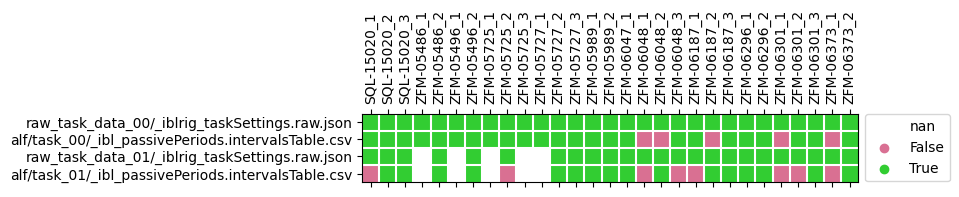

In [5]:
# Check which task datasets exist for each session
qc_columns = qc_datasets['task00'] + qc_datasets['task01']
qcval2num = {np.nan: 0., False: 0.1, True: 1.}
xticklabels = ['subject', 'session_n']
ax = plots.qc_grid(df_sessions, qc_columns, qcval2num=qcval2num, xticklabels=xticklabels)

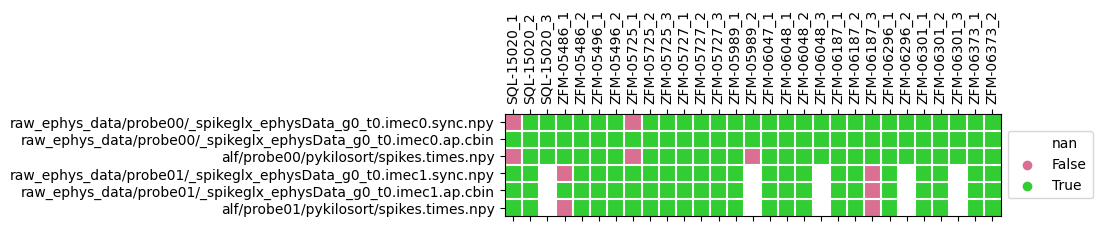

In [6]:
# Check which ephys datasets exist for each session
qc_columns = qc_datasets['probe00'] + qc_datasets['probe01']
qcval2num = {np.nan: 0., False: 0.1, True: 1.}
xticklabels = ['subject', 'session_n']
ax = plots.qc_grid(df_sessions, qc_columns, qcval2num=qcval2num, xticklabels=xticklabels)

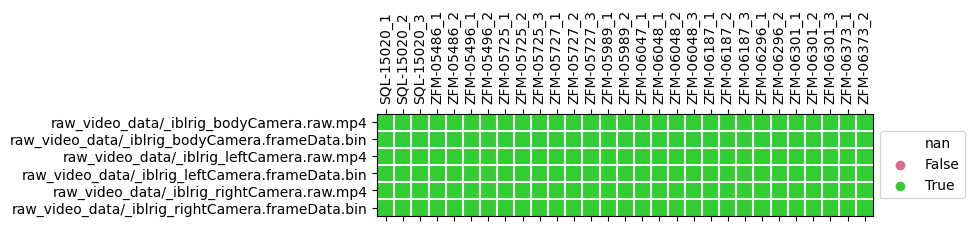

In [7]:
# Check which video datasets exist for each session
qc_columns = qc_datasets['video']
qcval2num = {np.nan: 0., False: 0.1, True: 1.}
xticklabels = ['subject', 'session_n']
ax = plots.qc_grid(df_sessions, qc_columns,  qcval2num=qcval2num, xticklabels=xticklabels)

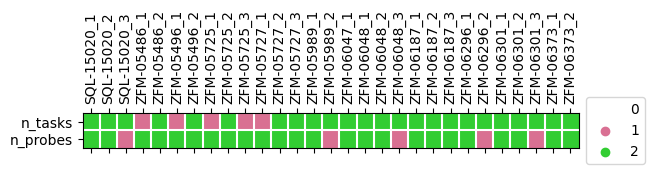

In [17]:
# Check which sessions have the appropriate number of probes and tasks
qc_columns = ['n_tasks', 'n_probes']
qcval2num = {0: 0., 1: 0.1, 2: 1.}
xticklabels = ['subject', 'session_n']
ax = plots.qc_grid(df_sessions, qc_columns=qc_columns, qcval2num=qcval2num, xticklabels=xticklabels)

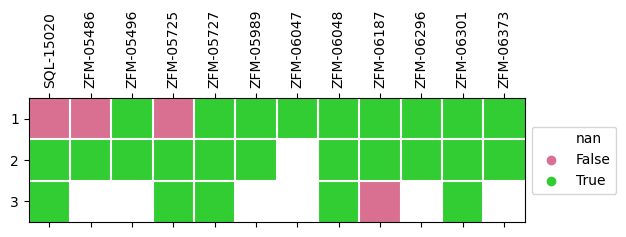

In [18]:
# Check which sessions have all the expected raw data
raw_cols = [col for col in df_sessions.columns if col.startswith('raw')]
df_sessions['data_complete'] = df_sessions.apply(lambda x: x[raw_cols].dropna().all(), axis='columns')
sessions_pivot = df_sessions.pivot(columns='session_n', index='subject', values='data_complete')
sessions_pivot = sessions_pivot.rename_axis(None, axis='columns')
ax = plots.qc_grid(sessions_pivot, qcval2num={np.nan: 0., False: 0.1, True: 1.})
ax.set_xticklabels(sessions_pivot.index)
ax.tick_params(axis='x', rotation=90)

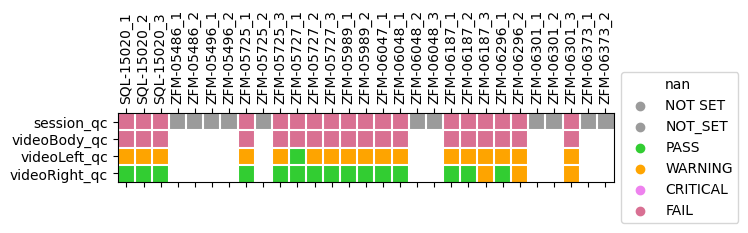

In [19]:
# Plot QC summary for the task and video
qc_columns = ['session_qc', 'videoBody_qc', 'videoLeft_qc', 'videoRight_qc']
xticklabels = ['subject', 'session_n']
ax = plots.qc_grid(df_sessions, qc_columns, xticklabels=xticklabels)

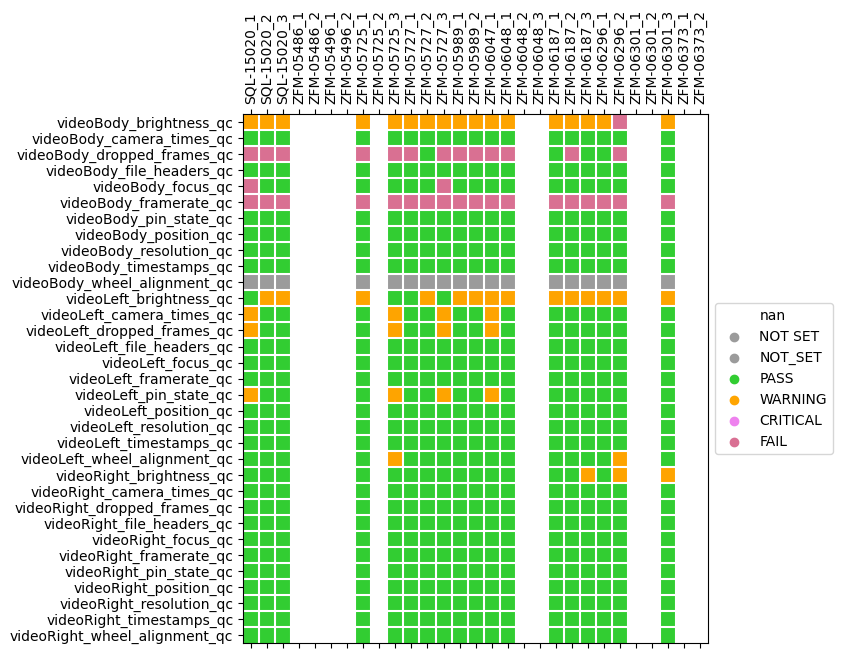

In [20]:
# Plot detailed video QC for each session
fig, ax = plt.subplots(figsize=(6, 8))
qc_columns = [col for col in df_sessions.columns if ('qc' in col) & (col.count('_') > 1)]
xticklabels = ['subject', 'session_n']
ax = plots.qc_grid(df_sessions, qc_columns=qc_columns, ax=ax, xticklabels=xticklabels)

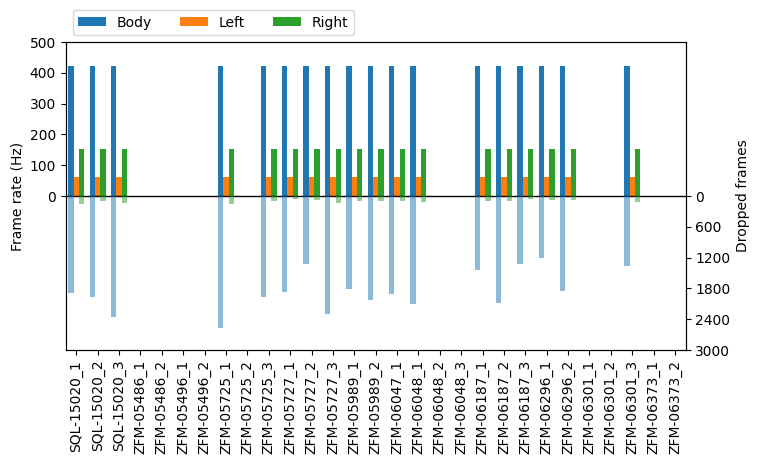

In [21]:
# Plot frame rate and number of dropped frames for each session & camera
fig, ax = plt.subplots(figsize=(8, 4))
ax2 = ax.twinx()

xpos = np.arange(len(df_sessions))

for offset, camera in zip([-0.25, 0., 0.25], ['Body', 'Left', 'Right']):
    framerate = df_sessions[f'video{camera}_framerate']
    ax.bar(xpos + offset, framerate, width=0.25, label=camera)
    dropped_frames = df_sessions[f'video{camera}_dropped_frames']
    ax2.bar(xpos + offset, -1 * dropped_frames, width=0.25, alpha=0.5)

ax.legend(loc='lower left', bbox_to_anchor=(0., 1.), ncol=3)

ax.set_xlim([-0.5, len(df_sessions) - 0.5])
ax.set_ylim([-500, 500])
ax.set_yticks(np.linspace(0, 500, 6))
ax.set_ylabel('Frame rate (Hz)')
ax2.set_ylim([-3000, 3000])
ax2.set_yticks(-1 * np.linspace(0, 3000, 6))
ax2.set_yticklabels(np.linspace(0, 3000, 6).astype(int))
ax2.set_ylabel('Dropped frames')
ax.axhline(0, color='black', lw=1)

ax.set_xticks(np.arange(len(df_sessions)))
ax.set_xticklabels(df_sessions.apply(lambda x: f"{x['subject']}_{x['session_n']}", axis='columns'))
ax.tick_params(axis='x', rotation=90)

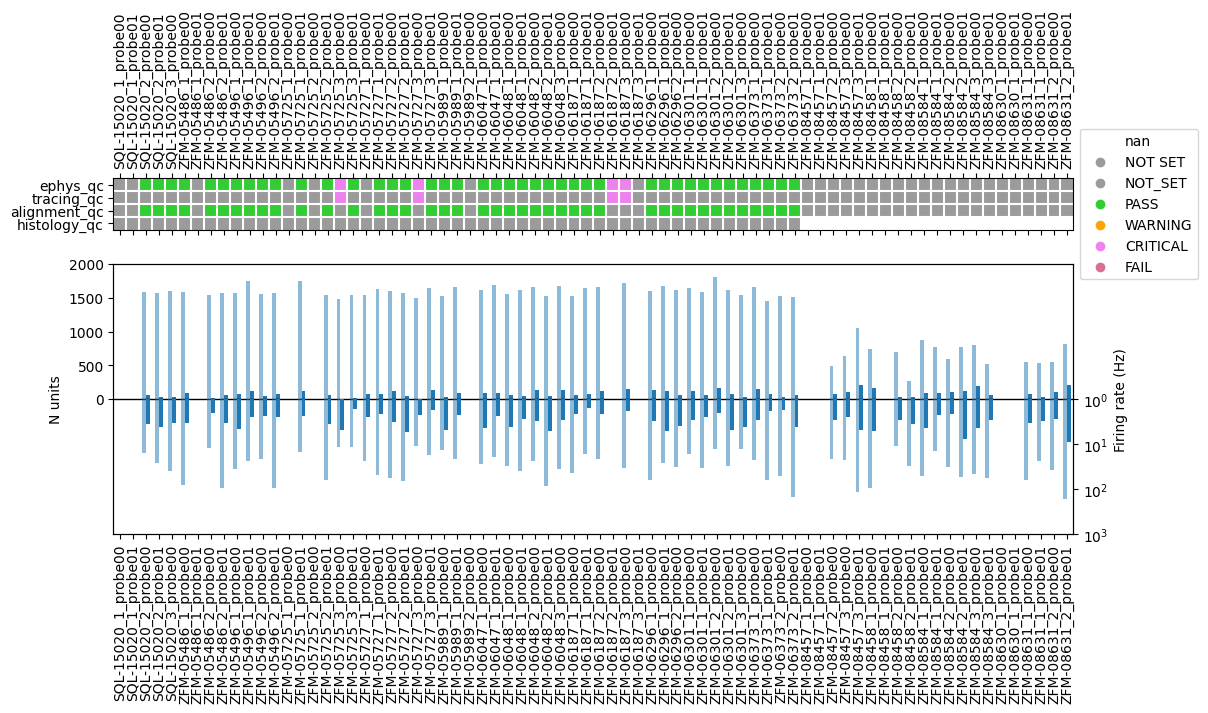

In [26]:
# Plot detailed ephys QC for ech session/probe
fig = plt.figure(figsize=(12, 6))
axs = [
    fig.add_axes([0.1, 0.5, 0.8, 0.3]),
    fig.add_axes([0.1, 0.1, 0.8, 0.45])
]

# Sort by subject
df_insertions = df_insertions.sort_values(['subject', 'session_n', 'probe'])

# QC grid plot
qc_columns = [col for col in df_insertions.columns if col.endswith('_qc')]
xticklabels = ['subject', 'session_n', 'probe']
axs[0] = plots.qc_grid(df_insertions, qc_columns, ax=axs[0], xticklabels=xticklabels)


# Bar plots for N units and firing rates
ax2 = axs[1].twinx()
xpos = np.arange(len(df_insertions))
offests = [-0.15, 0.15]
alphas = [0.5, 1.]
units_cols = ['n_units', 'n_units_qc_pass']
rate_cols = ['firing_rate_max', 'firing_rate_median']
for offset, units_col, rate_col, alpha in zip(offests, units_cols, rate_cols, alphas):
    n_units = df_insertions[units_col]
    axs[1].bar(xpos + offset, n_units, width=0.3, color='C0', alpha=alpha)
    firing_rate = df_insertions[rate_col]
    ax2.bar(xpos + offset, -1 * np.log10(firing_rate),  width=0.3, color='C0', alpha=alpha)
axs[1].set_xlim([-0.5, len(df_insertions) - 0.5])
axs[1].set_ylim([-2000, 2000])
axs[1].set_yticks(np.linspace(0, 2000, 5))
axs[1].set_ylabel('N units')
ax2.set_ylim([-3, 3])
ax2.set_yticks(-1 * np.linspace(0, 3, 4))
ax2.set_yticklabels(f'$10^{tick}$' for tick in np.linspace(0, 3, 4).astype(int))
ax2.set_ylabel('Firing rate (Hz)')
axs[1].axhline(0, color='black', lw=1)
axs[1].set_xticks(np.arange(len(df_insertions)))
axs[1].set_xticklabels(df_insertions.apply(lambda x: f"{x['subject']}_{x['session_n']}_{x['probe']}", axis='columns'))
axs[1].tick_params(axis='x', rotation=90)

Text(0.5, 0, 'Time from LSD administration (min)')

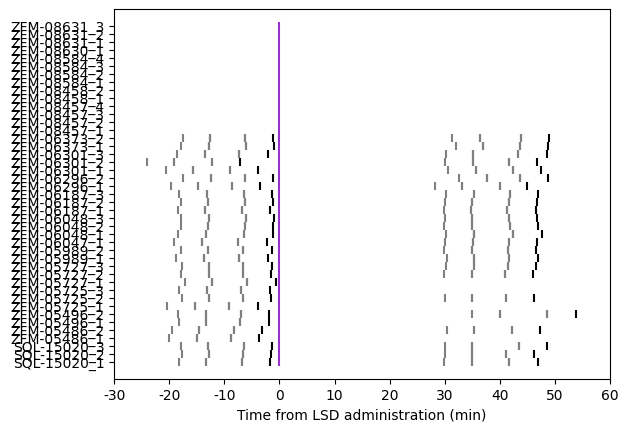

In [27]:
# Plot protocol timings for all sessions
epochs = ['spontaneous', 'rfm', 'replay']
fig, ax = plt.subplots()
for idx, session in df_sessions.iterrows():
    t0 = session['LSD_admin']
    ax.scatter(0, idx, marker='|', color='darkorchid')
    for task in ['task00', 'task01']:
        for epoch in epochs:
            ax.scatter(session[f'{task}_{epoch}_start'] - t0, idx, marker='|', color='gray')
            ax.scatter(session[f'{task}_{epoch}_stop'] - t0, idx, marker='|', color='black')
ax.set_yticks(np.arange(len(df_sessions)))
ax.set_yticklabels(df_sessions.apply(lambda x: f"{x['subject']}_{x['session_n']}", axis='columns'))
ax.set_xticks(np.linspace(-30, 60, 10) * 60)
ax.set_xticklabels(np.linspace(-30, 60, 10).astype(int))
ax.set_xlabel('Time from LSD administration (min)')

# Fetch spike data

In [ ]:
# Choose to save unit info
uinfo_file = paths['spikes']  # download spike times and save to file
# uinfo_file = ''  # only fetch cluster info

# Choose to save spike times as well as cluster info
spike_file = paths['spikes']  # download spike times and save to file
# spike_file = ''  # only fetch cluster info

# Download cluster info and spike times from server
df_units = io.fetch_unit_info(one, df_insertions, uinfo_file=uinfo_file, spike_file=spike_file)

  1%|█▋                                                                                                                               | 1/74 [00:03<03:48,  3.13s/it]

2025-03-25 16:01:59 WARNING  one.py:359  Histology tracing for probe01 does not exist. No channels for probe01
alf/probe01/pykilosort


  3%|███▍                                                                                                                             | 2/74 [00:07<04:27,  3.71s/it]

alf/probe00/pykilosort


  4%|█████▏                                                                                                                           | 3/74 [00:19<08:55,  7.55s/it]

alf/probe01/pykilosort


  5%|██████▉                                                                                                                          | 4/74 [00:33<12:02, 10.33s/it]

alf/probe00/pykilosort


  7%|████████▋                                                                                                                        | 5/74 [00:44<11:55, 10.36s/it]

alf/probe00/pykilosort


  9%|████████████▏                                                                                                                    | 7/74 [01:01<09:40,  8.67s/it]

alf/probe00/pykilosort


 11%|█████████████▉                                                                                                                   | 8/74 [01:09<09:04,  8.24s/it]

alf/probe01/pykilosort


 12%|███████████████▋                                                                                                                 | 9/74 [01:30<13:21, 12.34s/it]

alf/probe00/pykilosort


 14%|█████████████████▎                                                                                                              | 10/74 [01:51<15:49, 14.84s/it]

alf/probe01/pykilosort


 15%|███████████████████                                                                                                             | 11/74 [02:05<15:23, 14.67s/it]

alf/probe00/pykilosort


 16%|████████████████████▊                                                                                                           | 12/74 [02:21<15:36, 15.10s/it]

alf/probe01/pykilosort


 19%|████████████████████████▏                                                                                                       | 14/74 [02:39<11:23, 11.40s/it]

alf/probe01/pykilosort


 20%|█████████████████████████▉                                                                                                      | 15/74 [02:57<13:08, 13.36s/it]local file size mismatch on dataset: mainenlab/Subjects/ZFM-05725/2023-01-31/001/alf/probe00/pykilosort/clusters.metrics.pqt

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05725/2023-01-31/001/alf/probe00/pykilosort/clusters.metrics.pqt:   0%| | 0.00
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05725/2023-01-31/001/alf/probe00/pykilosort/clusters.metrics.pqt: 100%|█| 81.8


alf/probe00/pykilosort


 22%|███████████████████████████▋                                                                                                    | 16/74 [03:12<13:12, 13.67s/it]

alf/probe01/pykilosort


 23%|█████████████████████████████▍                                                                                                  | 17/74 [03:25<13:02, 13.73s/it]

2025-03-25 16:05:25 WARNING  one.py:359  Histology tracing for probe00 does not exist. No channels for probe00
alf/probe00/pykilosort


 24%|███████████████████████████████▏                                                                                                | 18/74 [03:32<10:55, 11.70s/it]

alf/probe01/pykilosort


 26%|████████████████████████████████▊                                                                                               | 19/74 [03:37<08:48,  9.61s/it]

alf/probe00/pykilosort


 27%|██████████████████████████████████▌                                                                                             | 20/74 [03:54<10:36, 11.78s/it]

alf/probe01/pykilosort


 28%|████████████████████████████████████▎                                                                                           | 21/74 [04:06<10:21, 11.72s/it]

alf/probe00/pykilosort


 30%|██████████████████████████████████████                                                                                          | 22/74 [04:23<11:40, 13.48s/it]

alf/probe01/pykilosort


 31%|███████████████████████████████████████▊                                                                                        | 23/74 [04:39<12:06, 14.25s/it]

2025-03-25 16:06:38 WARNING  one.py:359  Histology tracing for probe00 does not exist. No channels for probe00
alf/probe00/pykilosort


 32%|█████████████████████████████████████████▌                                                                                      | 24/74 [04:45<09:40, 11.62s/it]

alf/probe01/pykilosort


 34%|███████████████████████████████████████████▏                                                                                    | 25/74 [04:53<08:36, 10.54s/it]

alf/probe00/pykilosort


 35%|████████████████████████████████████████████▉                                                                                   | 26/74 [05:03<08:17, 10.36s/it]

alf/probe01/pykilosort


 38%|████████████████████████████████████████████████▍                                                                               | 28/74 [05:11<05:19,  6.95s/it]

alf/probe00/pykilosort


 39%|██████████████████████████████████████████████████▏                                                                             | 29/74 [05:25<06:51,  9.14s/it]

alf/probe01/pykilosort


 41%|███████████████████████████████████████████████████▉                                                                            | 30/74 [05:34<06:45,  9.21s/it]

alf/probe00/pykilosort


 42%|█████████████████████████████████████████████████████▌                                                                          | 31/74 [05:46<07:00,  9.79s/it]

alf/probe01/pykilosort


 43%|███████████████████████████████████████████████████████▎                                                                        | 32/74 [05:52<06:03,  8.66s/it]

alf/probe00/pykilosort


 45%|█████████████████████████████████████████████████████████                                                                       | 33/74 [06:05<06:55, 10.14s/it]

alf/probe01/pykilosort


 46%|██████████████████████████████████████████████████████████▊                                                                     | 34/74 [06:18<07:19, 10.98s/it]

alf/probe00/pykilosort


 47%|████████████████████████████████████████████████████████████▌                                                                   | 35/74 [06:33<07:52, 12.10s/it]

alf/probe00/pykilosort


 49%|██████████████████████████████████████████████████████████████▎                                                                 | 36/74 [06:45<07:44, 12.22s/it]

alf/probe01/pykilosort


 50%|████████████████████████████████████████████████████████████████                                                                | 37/74 [06:54<06:49, 11.08s/it]

alf/probe00/pykilosort


 51%|█████████████████████████████████████████████████████████████████▋                                                              | 38/74 [07:06<06:51, 11.43s/it]

2025-03-25 16:09:03 WARNING  one.py:359  Histology tracing for probe01 does not exist. No channels for probe01
alf/probe01/pykilosort


 53%|███████████████████████████████████████████████████████████████████▍                                                            | 39/74 [07:11<05:26,  9.34s/it]

2025-03-25 16:09:09 WARNING  one.py:359  Histology tracing for probe00 does not exist. No channels for probe00
alf/probe00/pykilosort


 55%|██████████████████████████████████████████████████████████████████████▉                                                         | 41/74 [07:25<04:09,  7.56s/it]

alf/probe00/pykilosort


 57%|████████████████████████████████████████████████████████████████████████▋                                                       | 42/74 [07:43<05:46, 10.82s/it]

alf/probe01/pykilosort


 58%|██████████████████████████████████████████████████████████████████████████▍                                                     | 43/74 [08:03<06:55, 13.42s/it]

alf/probe00/pykilosort


 59%|████████████████████████████████████████████████████████████████████████████                                                    | 44/74 [08:14<06:29, 12.98s/it]

alf/probe00/pykilosort


 61%|█████████████████████████████████████████████████████████████████████████████▊                                                  | 45/74 [08:28<06:22, 13.20s/it]

alf/probe01/pykilosort


 62%|███████████████████████████████████████████████████████████████████████████████▌                                                | 46/74 [08:36<05:24, 11.60s/it]

alf/probe00/pykilosort


 64%|█████████████████████████████████████████████████████████████████████████████████▎                                              | 47/74 [08:50<05:30, 12.24s/it]

alf/probe01/pykilosort


 65%|███████████████████████████████████████████████████████████████████████████████████                                             | 48/74 [09:04<05:32, 12.78s/it]

alf/probe00/pykilosort


 66%|████████████████████████████████████████████████████████████████████████████████████▊                                           | 49/74 [09:11<04:34, 10.96s/it]

alf/probe00/pykilosort


 68%|██████████████████████████████████████████████████████████████████████████████████████▍                                         | 50/74 [09:27<05:02, 12.59s/it]

alf/probe01/pykilosort


 69%|████████████████████████████████████████████████████████████████████████████████████████▏                                       | 51/74 [09:35<04:19, 11.27s/it]

alf/probe00/pykilosort


 70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                      | 52/74 [09:43<03:48, 10.37s/it]

alf/probe01/pykilosort


 74%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                | 55/74 [10:02<02:03,  6.49s/it]

2025-03-25 16:12:01 WARNING  one.py:359  Histology tracing for probe00 does not exist. No channels for probe00
alf/probe00/iblsorter



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08457/2025-03-13/001/alf/probe00/iblsorter/spikes.clusters.npy:   0%| | 0.00/2
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08457/2025-03-13/001/alf/probe00/iblsorter/spikes.clusters.npy:   1%| | 262k/2
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08457/2025-03-13/001/alf/probe00/iblsorter/spikes.clusters.npy:   2%| | 524k/2
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08457/2025-03-13/001/alf/probe00/iblsorter/spikes.clusters.npy:   3%| | 786k/2
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08457/2025-03-13/001/alf/probe00/iblsorter/spikes.clusters.npy:   3%| | 786k/2
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08457/2025-03-13/001/alf/probe00/iblsorter/spikes.clusters.npy:   4%| | 1.05M/
(S3

2025-03-25 16:20:39 WARNING  one.py:359  Histology tracing for probe00 does not exist. No channels for probe00
alf/probe00/iblsorter



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08457/2025-03-18/001/alf/probe00/iblsorter/spikes.clusters.npy:   0%| | 0.00/2
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08457/2025-03-18/001/alf/probe00/iblsorter/spikes.clusters.npy:   1%| | 262k/2
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08457/2025-03-18/001/alf/probe00/iblsorter/spikes.clusters.npy:   3%| | 786k/2
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08457/2025-03-18/001/alf/probe00/iblsorter/spikes.clusters.npy:   4%| | 1.31M/
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08457/2025-03-18/001/alf/probe00/iblsorter/spikes.clusters.npy:   5%| | 1.57M/
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08457/2025-03-18/001/alf/probe00/iblsorter/spikes.clusters.npy:   9%| | 2.62M/
(S3

2025-03-25 16:21:43 WARNING  one.py:359  Histology tracing for probe01 does not exist. No channels for probe01
alf/probe01/iblsorter



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08457/2025-03-18/001/alf/probe01/iblsorter/spikes.clusters.npy:   0%| | 0.00/6
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08457/2025-03-18/001/alf/probe01/iblsorter/spikes.clusters.npy:   0%| | 262k/6
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08457/2025-03-18/001/alf/probe01/iblsorter/spikes.clusters.npy:   1%| | 524k/6
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08457/2025-03-18/001/alf/probe01/iblsorter/spikes.clusters.npy:   1%| | 786k/6
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08457/2025-03-18/001/alf/probe01/iblsorter/spikes.clusters.npy:   2%| | 1.05M/
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08457/2025-03-18/001/alf/probe01/iblsorter/spikes.clusters.npy:   3%| | 1.84M/
(S3

2025-03-25 16:23:34 WARNING  one.py:359  Histology tracing for probe00 does not exist. No channels for probe00
alf/probe00/iblsorter



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08458/2025-03-14/001/alf/probe00/iblsorter/spikes.clusters.npy:   0%| | 0.00/2
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08458/2025-03-14/001/alf/probe00/iblsorter/spikes.clusters.npy:   1%| | 262k/2
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08458/2025-03-14/001/alf/probe00/iblsorter/spikes.clusters.npy:   3%| | 524k/2
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08458/2025-03-14/001/alf/probe00/iblsorter/spikes.clusters.npy:   5%| | 1.05M/
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08458/2025-03-14/001/alf/probe00/iblsorter/spikes.clusters.npy:   9%| | 1.84M/
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08458/2025-03-14/001/alf/probe00/iblsorter/spikes.clusters.npy:  15%|▏| 3.15M/
(S3

2025-03-25 16:24:27 WARNING  one.py:359  Histology tracing for probe01 does not exist. No channels for probe01
alf/probe01/iblsorter



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08458/2025-03-14/001/alf/probe01/iblsorter/spikes.clusters.npy:   0%| | 0.00/2
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08458/2025-03-14/001/alf/probe01/iblsorter/spikes.clusters.npy:   1%| | 262k/2
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08458/2025-03-14/001/alf/probe01/iblsorter/spikes.clusters.npy:   2%| | 524k/2
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08458/2025-03-14/001/alf/probe01/iblsorter/spikes.clusters.npy:   5%| | 1.31M/
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08458/2025-03-14/001/alf/probe01/iblsorter/spikes.clusters.npy:   9%| | 2.10M/
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08458/2025-03-14/001/alf/probe01/iblsorter/spikes.clusters.npy:  14%|▏| 3.41M/
(S3

2025-03-25 16:25:16 WARNING  one.py:359  Histology tracing for probe00 does not exist. No channels for probe00
alf/probe00/iblsorter



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08584/2025-03-17/001/alf/probe00/iblsorter/spikes.clusters.npy:   0%| | 0.00/3
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08584/2025-03-17/001/alf/probe00/iblsorter/spikes.clusters.npy:   1%| | 262k/3
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08584/2025-03-17/001/alf/probe00/iblsorter/spikes.clusters.npy:   2%| | 524k/3
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08584/2025-03-17/001/alf/probe00/iblsorter/spikes.clusters.npy:   2%| | 786k/3
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08584/2025-03-17/001/alf/probe00/iblsorter/spikes.clusters.npy:   5%| | 1.57M/
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08584/2025-03-17/001/alf/probe00/iblsorter/spikes.clusters.npy:  10%| | 3.15M/
(S3

2025-03-25 16:26:19 WARNING  one.py:359  Histology tracing for probe01 does not exist. No channels for probe01
alf/probe01/iblsorter



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08584/2025-03-17/001/alf/probe01/iblsorter/spikes.clusters.npy:   0%| | 0.00/5
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08584/2025-03-17/001/alf/probe01/iblsorter/spikes.clusters.npy:   0%| | 262k/5
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08584/2025-03-17/001/alf/probe01/iblsorter/spikes.clusters.npy:   1%| | 524k/5
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08584/2025-03-17/001/alf/probe01/iblsorter/spikes.clusters.npy:   1%| | 786k/5
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08584/2025-03-17/001/alf/probe01/iblsorter/spikes.clusters.npy:   3%| | 1.57M/
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08584/2025-03-17/001/alf/probe01/iblsorter/spikes.clusters.npy:   6%| | 3.41M/
(S3

2025-03-25 16:28:02 WARNING  one.py:359  Histology tracing for probe00 does not exist. No channels for probe00
alf/probe00/iblsorter



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08584/2025-03-19/001/alf/probe00/iblsorter/spikes.clusters.npy:   0%| | 0.00/5
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08584/2025-03-19/001/alf/probe00/iblsorter/spikes.clusters.npy:   0%| | 262k/5
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08584/2025-03-19/001/alf/probe00/iblsorter/spikes.clusters.npy:   1%| | 524k/5
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08584/2025-03-19/001/alf/probe00/iblsorter/spikes.clusters.npy:   2%| | 1.05M/
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08584/2025-03-19/001/alf/probe00/iblsorter/spikes.clusters.npy:   4%| | 2.10M/
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08584/2025-03-19/001/alf/probe00/iblsorter/spikes.clusters.npy:   7%| | 3.93M/
(S3

2025-03-25 16:30:00 WARNING  one.py:359  Histology tracing for probe01 does not exist. No channels for probe01
alf/probe01/iblsorter



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08584/2025-03-19/001/alf/probe01/iblsorter/spikes.clusters.npy:   0%| | 0.00/2
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08584/2025-03-19/001/alf/probe01/iblsorter/spikes.clusters.npy:   1%| | 262k/2
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08584/2025-03-19/001/alf/probe01/iblsorter/spikes.clusters.npy:   3%| | 524k/2
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08584/2025-03-19/001/alf/probe01/iblsorter/spikes.clusters.npy:   4%| | 786k/2
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08584/2025-03-19/001/alf/probe01/iblsorter/spikes.clusters.npy:   8%| | 1.57M/
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08584/2025-03-19/001/alf/probe01/iblsorter/spikes.clusters.npy:  14%|▏| 2.88M/
(S3

2025-03-25 16:31:22 WARNING  one.py:359  Histology tracing for probe00 does not exist. No channels for probe00
alf/probe00/iblsorter



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08631/2025-03-12/001/alf/probe00/iblsorter/spikes.clusters.npy:   0%| | 0.00/3
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08631/2025-03-12/001/alf/probe00/iblsorter/spikes.clusters.npy:   1%| | 262k/3
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08631/2025-03-12/001/alf/probe00/iblsorter/spikes.clusters.npy:   1%| | 524k/3
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08631/2025-03-12/001/alf/probe00/iblsorter/spikes.clusters.npy:   4%| | 1.57M/
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08631/2025-03-12/001/alf/probe00/iblsorter/spikes.clusters.npy:   5%| | 2.10M/
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08631/2025-03-12/001/alf/probe00/iblsorter/spikes.clusters.npy:   7%| | 2.88M/
(S3

2025-03-25 16:32:13 WARNING  one.py:359  Histology tracing for probe01 does not exist. No channels for probe01
alf/probe01/iblsorter



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08631/2025-03-12/001/alf/probe01/iblsorter/spikes.times.npy:   0%| | 0.00/115M
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08631/2025-03-12/001/alf/probe01/iblsorter/spikes.times.npy:   0%| | 262k/115M
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08631/2025-03-12/001/alf/probe01/iblsorter/spikes.times.npy:   0%| | 524k/115M
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08631/2025-03-12/001/alf/probe01/iblsorter/spikes.times.npy:   1%| | 786k/115M
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08631/2025-03-12/001/alf/probe01/iblsorter/spikes.times.npy:   1%| | 1.57M/115
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-08631/2025-03-12/001/alf/probe01/iblsorter/spikes.times.npy:   3%| | 3.15M/115
(S3

In [4]:
# Load cluster info from file
df_units = pd.read_parquet(paths['units'])

In [115]:
df_units['region'] = df_units['region'].replace({np.nan: 'none'})

coarse_regions = atlas.combine_regions(df_units['region'])
region_counts = df_units.groupby('region').apply(len).sort_values(ascending=False)

/tmp/ipykernel_35103/2493651369.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  region_counts = df_units.groupby('region').apply(len).sort_values(ascending=False)


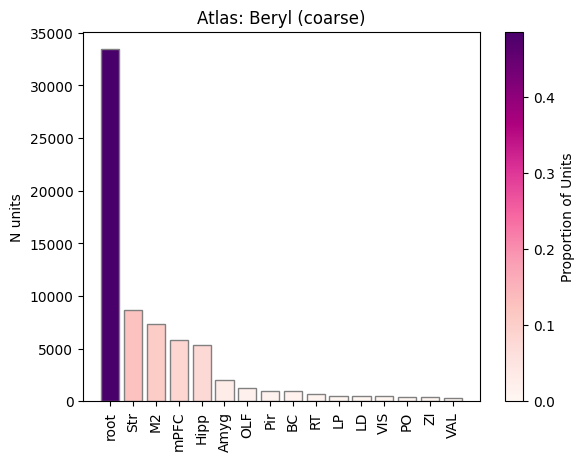

In [120]:
fig, ax = plt.subplots()
ax.set_title('Atlas: Beryl (coarse)')
cmap = cmaps['n_units']

region_names, counts = np.unique(coarse_regions, return_counts=True)
sorted_inds = np.argsort(-1 * counts)
props = counts / counts.sum()
colors = np.array([cmap(p) for p in props / props.max()])

ax.bar(np.arange(len(counts)), counts[sorted_inds], fc=colors[sorted_inds], ec='gray')
ax.tick_params(axis='x', rotation=90)
ax.set_xticks(np.arange(len(counts)))
ax.set_xticklabels(region_names[sorted_inds])
ax.set_ylabel('N units')

mappable = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, props.max()), cmap=cmap)
cbar = fig.colorbar(mappable, ax=ax, label='Proportion of Units')

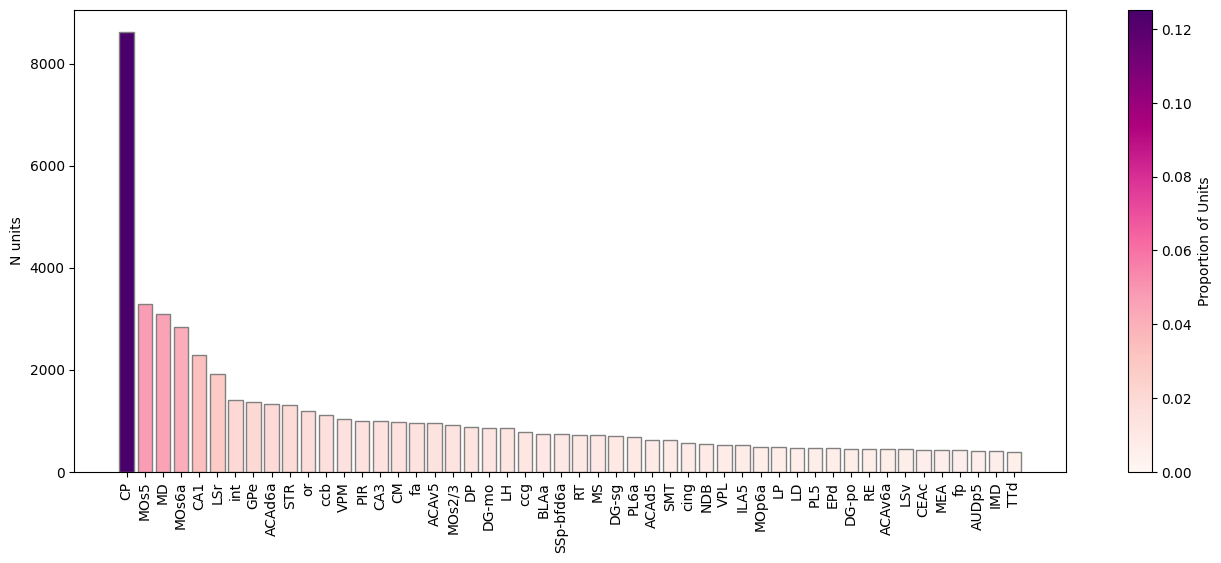

In [121]:
fig, ax = plt.subplots(figsize=(16, 6))
cmap = cmaps['n_units']
n_regions = 50

props = region_counts / region_counts.sum()
colors = np.array([cmap(p) for p in props / props.max()])

ax.bar(np.arange(n_regions), region_counts[:n_regions], fc=colors[:n_regions], ec='gray')
ax.set_xticks(np.arange(n_regions))
ax.set_xticklabels(region_counts[:n_regions].index)
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('N units')

mappable = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, props.max()), cmap=cmap)
cbar = fig.colorbar(mappable, ax=ax, label='Proportion of Units')

In [90]:
# Plot distribution of units across brain regions
from iblutil.numerical import ismember
from iblatlas.atlas import AllenAtlas, BrainRegions
import iblatlas.plots as anatomyplots
atlas = AllenAtlas(res_um=50)
regions = BrainRegions()

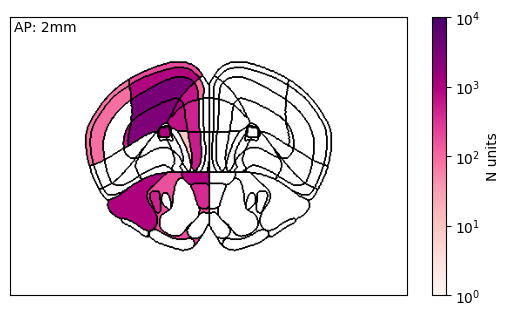

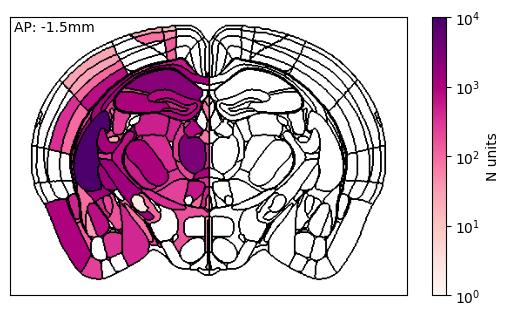

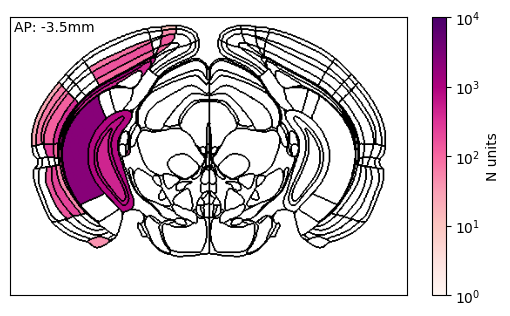

In [97]:
for ap_coord in ap_coords:
    fig, ax, cbar = anatomyplots.plot_scalar_on_slice(
        region_counts.index, 
        np.log10(region_counts.values),
        coord=ap_coord * 1000,  # in um
        background='boundary',
        atlas=atlas,
        clevels=[0, 4],
        cmap=cmap,
        show_cbar=True,
    )
    ax.text(0.01, 0.95, f'AP: {ap_coord}mm', transform=ax.transAxes)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax_pos = ax.get_position()  # returns [left, bottom, width, height]
    cbar_pos = cbar.ax.get_position()
    cbar.ax.set_position([cbar_pos.x0, ax_pos.y0, cbar_pos.width, ax_pos.height])
    cbar.set_ticks(np.linspace(0, 4, 5))
    cbar.set_ticklabels(['$10^{%d}$' % tick for tick in np.linspace(0, 4, 5)])
    cbar.set_label('N units')

In [9]:
# Make a query and load spike times
eid = 'a7a4a70f-57ae-4586-bb2d-37422deca541'  # pick a recording session
df_session = df_units.query('eid == @eid')
df_spikes = io.load_units('data/spikes', df_session['uuid'])  # load the spike times

# Control data

In [25]:
df_bwm = io.fetch_BWM_task_starts(one)

100%|███████████████████████████████████████| 1068/1068 [02:23<00:00,  7.45it/s]


In [3]:
df_bwm = pd.read_csv('metadata/BWM_task_starts.csv')

Sessions with pre-task period > 5.00min: 26


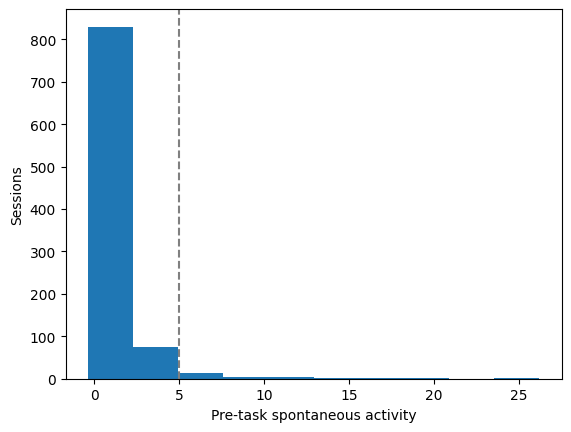

In [4]:
cutoff = 300 

fig, ax = plt.subplots()
ax.hist(df_bwm['task_start'] / 60)
ax.axvline(cutoff / 60, ls='--', color='gray')
ax.set_ylabel('Sessions')
ax.set_xlabel('Pre-task spontaneous activity')

df_controls = df_bwm.query('task_start > @cutoff')
print(f'Sessions with pre-task period > {cutoff / 60:.2f}min: {len(df_controls)}')

In [5]:
df_insertions_bwm = io.fetch_BWM_insertions(one, df_controls)

100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 681.65it/s]


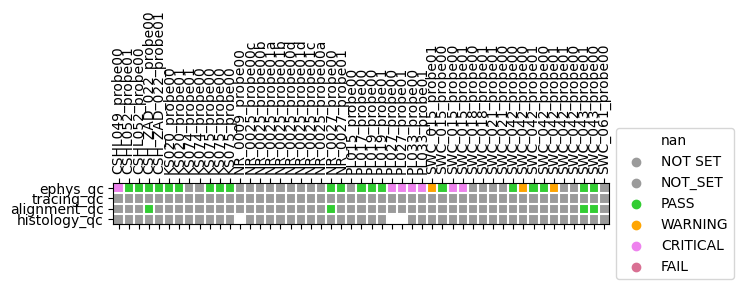

In [6]:
# QC grid plot
qc_columns = [col for col in df_insertions_bwm.columns if col.endswith('_qc')]
xticklabels = ['subject', 'probe']
ax = plots.qc_grid(df_insertions_bwm, qc_columns, xticklabels=xticklabels)

In [3]:
df_insertions_bwm = pd.read_csv(paths['BWM_insertions'])

In [4]:
df_uinfo = io.fetch_unit_info(one, df_insertions_bwm, uinfo_file=paths['BWM_units'], spike_file=paths['BWM_spikes'])

  0%|                                                    | 0/49 [00:00<?, ?it/s]

alf/probe00



  2%|▉                                           | 1/49 [00:05<04:43,  5.91s/it]

alf/probe01/pykilosort



100%|███████████████████████████████████████| 1031/1031 [00:36<00:00, 28.61it/s]


alf/probe01



  4%|█▊                                          | 2/49 [01:01<27:25, 35.00s/it]

alf/probe00/pykilosort



100%|█████████████████████████████████████████| 771/771 [00:29<00:00, 26.30it/s]


alf/probe00



  6%|██▋                                         | 3/49 [01:41<28:45, 37.52s/it]

alf/probe00/pykilosort



100%|█████████████████████████████████████████| 763/763 [00:31<00:00, 24.27it/s]


alf/probe00



  8%|███▌                                        | 4/49 [02:32<32:10, 42.91s/it]

alf/probe01/pykilosort



 10%|████▍                                       | 5/49 [03:23<33:31, 45.71s/it]

alf/probe00/pykilosort



100%|█████████████████████████████████████████| 309/309 [00:26<00:00, 11.72it/s]


alf/probe00



 12%|█████▍                                      | 6/49 [03:56<29:42, 41.46s/it]

alf/probe01



100%|█████████████████████████████████████████| 827/827 [00:08<00:00, 93.92it/s]


alf/probe01/pykilosort



 14%|██████▎                                     | 7/49 [04:17<24:11, 34.55s/it]

alf/probe01/pykilosort



 16%|███████▏                                    | 8/49 [04:37<20:34, 30.12s/it]

alf/probe00/pykilosort



 18%|████████                                    | 9/49 [04:41<14:33, 21.83s/it]/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2023-04-05"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


alf/probe00/pykilosort



 20%|████████▊                                  | 10/49 [04:47<10:56, 16.84s/it]

alf/probe00/pykilosort



 22%|█████████▋                                 | 11/49 [04:51<08:18, 13.11s/it]

alf/probe00/pykilosort



 24%|██████████▌                                | 12/49 [04:58<06:58, 11.31s/it]local file size mismatch on dataset: steinmetzlab/Subjects/NR_0009/2021-08-11/002/alf/probe00/pykilosort/clusters.uuids.csv

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub


alf/probe00/pykilosort



 27%|███████████▍                               | 13/49 [05:04<05:44,  9.58s/it]local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00c/pykilosort/clusters.uuids.csv
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00c/pykilosort/clusters.depths.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00c/pykilosort/clusters.metrics.pqt
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00c/pykilosort/clusters.channels.npy

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) 

alf/probe00c/pykilosort



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloa

alf/probe00b/pykilosort



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub

 31%|█████████████▏                             | 15/49 [05:28<05:59, 10.58s/it]local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01a/pykilosort/c

alf/probe01a/pykilosort



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Download

alf/probe01b/pykilosort



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Download

alf/probe00d/pykilosort



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Download

alf/probe01d/pykilosort



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloa

alf/probe01c/pykilosort



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Download

alf/probe00a/pykilosort



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Download

alf/probe00/pykilosort



 45%|███████████████████▎                       | 22/49 [07:16<09:05, 20.19s/it]

alf/probe01/pykilosort



 47%|████████████████████▏                      | 23/49 [07:59<11:42, 27.01s/it]local file size mismatch on dataset: hausserlab/Subjects/PL015/2022-07-26/004/alf/probe00/pykilosort/clusters.metrics.pqt
local file size mismatch on dataset: hausserlab/Subjects/PL015/2022-07-26/004/alf/probe00/pykilosort/clusters.depths.npy
local file size mismatch on dataset: hausserlab/Subjects/PL015/2022-07-26/004/alf/probe00/pykilosort/clusters.channels.npy
local file size mismatch on dataset: hausserlab/Subjects/PL015/2022-07-26/004/alf/probe00/pykilosort/clusters.uuids.csv

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downlo

alf/probe00/pykilosort



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Download

alf/probe00/pykilosort



 51%|█████████████████████▉                     | 25/49 [08:53<11:13, 28.07s/it]

alf/probe00/pykilosort



 53%|██████████████████████▊                    | 26/49 [08:58<08:04, 21.06s/it]

alf/probe01/pykilosort



 55%|███████████████████████▋                   | 27/49 [09:00<05:38, 15.38s/it]local file size mismatch on dataset: hausserlab/Subjects/PL027/2022-10-28/001/alf/probe00/pykilosort/clusters.channels.npy
local file size mismatch on dataset: hausserlab/Subjects/PL027/2022-10-28/001/alf/probe00/pykilosort/clusters.uuids.csv
local file size mismatch on dataset: hausserlab/Subjects/PL027/2022-10-28/001/alf/probe00/pykilosort/clusters.metrics.pqt
local file size mismatch on dataset: hausserlab/Subjects/PL027/2022-10-28/001/alf/probe00/pykilosort/clusters.depths.npy

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downlo

alf/probe00/pykilosort



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Download

alf/probe01/pykilosort



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje

(S3) /home/crombie/Downloa

alf/probe00/pykilosort



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Download

alf/probe01/pykilosort



(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje

(S3) /home/crombie/Downloa

alf/probe01



100%|███████████████████████████████████████| 206/206 [00:00<00:00, 1062.94it/s]


alf/probe01/pykilosort



 65%|████████████████████████████               | 32/49 [09:59<03:10, 11.19s/it]

alf/probe00/pykilosort



100%|█████████████████████████████████████████| 381/381 [00:04<00:00, 84.47it/s]


alf/probe00



 67%|████████████████████████████▉              | 33/49 [10:08<02:52, 10.75s/it]

alf/probe00/pykilosort



100%|████████████████████████████████████████| 224/224 [00:01<00:00, 157.82it/s]


alf/probe00



 69%|█████████████████████████████▊             | 34/49 [10:17<02:33, 10.22s/it]

alf/probe01



100%|████████████████████████████████████████| 290/290 [00:00<00:00, 501.03it/s]


alf/probe01/pykilosort



 71%|██████████████████████████████▋            | 35/49 [10:21<01:57,  8.40s/it]

alf/probe00/pykilosort



100%|██████████████████████████████████████████| 63/63 [00:00<00:00, 148.05it/s]


alf/probe00



 73%|███████████████████████████████▌           | 36/49 [10:28<01:43,  7.97s/it]

alf/probe01/pykilosort



100%|█████████████████████████████████████████| 341/341 [00:04<00:00, 72.95it/s]


alf/probe01



 76%|████████████████████████████████▍          | 37/49 [10:37<01:38,  8.17s/it]

alf/probe01



100%|██████████████████████████████████████████| 82/82 [00:00<00:00, 998.49it/s]


alf/probe01/pykilosort



 78%|█████████████████████████████████▎         | 38/49 [10:43<01:21,  7.40s/it]

alf/probe00



100%|████████████████████████████████████████| 176/176 [00:00<00:00, 992.09it/s]


alf/probe00/pykilosort



 80%|██████████████████████████████████▏        | 39/49 [10:46<01:01,  6.15s/it]

alf/probe00



100%|██████████████████████████████████████| 1370/1370 [00:06<00:00, 226.00it/s]


alf/probe00/pykilosort



 82%|███████████████████████████████████        | 40/49 [11:47<03:23, 22.64s/it]

alf/probe00



100%|████████████████████████████████████████| 150/150 [00:00<00:00, 217.75it/s]


alf/probe00/pykilosort



 84%|███████████████████████████████████▉       | 41/49 [11:54<02:24, 18.02s/it]

alf/probe01



100%|██████████████████████████████████████████| 91/91 [00:00<00:00, 256.51it/s]


alf/probe01/pykilosort



 86%|████████████████████████████████████▊      | 42/49 [11:57<01:34, 13.56s/it]

alf/probe00/pykilosort



100%|█████████████████████████████████████████| 479/479 [00:05<00:00, 81.48it/s]


alf/probe00



 88%|█████████████████████████████████████▋     | 43/49 [12:16<01:30, 15.16s/it]/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2023-04-05"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


alf/probe01



100%|████████████████████████████████████████| 258/258 [00:00<00:00, 299.47it/s]


alf/probe01/pykilosort



 90%|██████████████████████████████████████▌    | 44/49 [12:21<01:00, 12.08s/it]

alf/probe01



100%|████████████████████████████████████████| 226/226 [00:01<00:00, 169.41it/s]


alf/probe01/pykilosort



 92%|███████████████████████████████████████▍   | 45/49 [12:30<00:44, 11.02s/it]

alf/probe00/pykilosort



 94%|████████████████████████████████████████▎  | 46/49 [12:50<00:41, 13.74s/it]

alf/probe01/pykilosort



100%|███████████████████████████████████████| 1542/1542 [00:31<00:00, 48.61it/s]


alf/probe01/ks2_preproc_tests



100%|██████████████████████████████████████| 1542/1542 [00:09<00:00, 155.16it/s]


alf/probe01



 96%|█████████████████████████████████████████▏ | 47/49 [13:56<00:58, 29.43s/it]

alf/probe00/pykilosort



100%|█████████████████████████████████████████| 819/819 [00:15<00:00, 52.68it/s]


alf/probe00



 98%|██████████████████████████████████████████ | 48/49 [14:20<00:27, 27.91s/it]

alf/probe00/pykilosort



100%|█████████████████████████████████████████| 361/361 [00:32<00:00, 11.18it/s]


alf/probe00



100%|███████████████████████████████████████████| 49/49 [15:05<00:00, 18.49s/it]


In [5]:
df_uinfo

,uuid,depth,channel,cluster_id,amp_max,amp_min,amp_median,amp_std_dB,contamination,contamination_alt,...,session_n,eid,probe,pid,histology,slidingRP_viol_forced,max_confidence,min_contamination,n_spikes_below2,bitwise_fail
0,71e1df3c-7ed9-43fa-8674-3a9308aa0b91,20.0,0,0,0.000226,0.000055,0.000064,1.504389,3.829949,1.456615,...,1,a74cc3b6-76ea-46d9-9801-a17c86ae485a,probe00,91d39dd3-c120-40bb-b643-35cfe9d31b02,,NaN,NaN,NaN,NaN,NaN
1,cc3e9420-d491-44f9-9b13-fbc0579ac236,40.0,2,1,0.000208,0.000096,0.000107,0.885881,0.021030,0.019257,...,1,a74cc3b6-76ea-46d9-9801-a17c86ae485a,probe00,91d39dd3-c120-40bb-b643-35cfe9d31b02,,NaN,NaN,NaN,NaN,NaN
2,91ab91da-b5db-4db8-914a-891bc258054f,80.0,7,2,0.000228,0.000110,0.000119,0.824494,0.254739,0.198360,...,1,a74cc3b6-76ea-46d9-9801-a17c86ae485a,probe00,91d39dd3-c120-40bb-b643-35cfe9d31b02,,NaN,NaN,NaN,NaN,NaN
3,97d535d5-274c-4ad0-92fa-54f4f1ff0747,140.0,12,3,0.000245,0.000096,0.000108,1.143302,1.767220,0.861790,...,1,a74cc3b6-76ea-46d9-9801-a17c86ae485a,probe00,91d39dd3-c120-40bb-b643-35cfe9d31b02,,NaN,NaN,NaN,NaN,NaN
4,6c97cff0-ff33-4ba2-a561-be2036a85a94,160.0,14,4,0.000300,0.000076,0.000110,1.621255,0.040865,0.037064,...,1,a74cc3b6-76ea-46d9-9801-a17c86ae485a,probe00,91d39dd3-c120-40bb-b643-35cfe9d31b02,,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,c5b531fc-a161-456e-ab4d-fa2aa2aa8443,1220.0,121,356,0.000101,0.000051,0.000074,1.086045,0.000000,0.000000,...,1,00d3c9ea-2c91-44c2-b03e-6dfec5e08f27,probe00,d0c78d67-2af3-44ac-b46f-4895e60ad4e3,,NaN,NaN,NaN,NaN,NaN
357,d5edbbe3-7f9b-48e6-8f97-67d3d303a9c1,1520.0,151,357,0.000107,0.000047,0.000061,1.669493,0.000000,0.000000,...,1,00d3c9ea-2c91-44c2-b03e-6dfec5e08f27,probe00,d0c78d67-2af3-44ac-b46f-4895e60ad4e3,,NaN,NaN,NaN,NaN,NaN
358,d72c4b26-d3b8-4222-808f-1e7d9bacb4d3,2240.0,223,358,0.000184,0.000088,0.000118,1.783457,0.000000,0.000000,...,1,00d3c9ea-2c91-44c2-b03e-6dfec5e08f27,probe00,d0c78d67-2af3-44ac-b46f-4895e60ad4e3,,NaN,NaN,NaN,NaN,NaN
359,cd1d51ac-8e9f-41de-a43c-6d638f219c12,480.0,47,359,0.000038,0.000035,0.000037,0.346502,0.000000,0.000000,...,1,00d3c9ea-2c91-44c2-b03e-6dfec5e08f27,probe00,d0c78d67-2af3-44ac-b46f-4895e60ad4e3,,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_spikes_bwm = io.fetch_units(one, df_insertions_bwm, uuid_file=paths['BWM_units'], spike_file=paths['BWM_spikes'], qc_tag=['ks2_label', 'good'])

  0%|                                                    | 0/49 [00:00<?, ?it/s]

2025-03-24 14:42:42 WARNING  one.py:359  Histology tracing for probe00 does not exist. No channels for probe00


  2%|▉                                           | 1/49 [00:12<09:45, 12.19s/it]/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:406: ALFWarning: No default revision for dataset alf/probe01/pykilosort/spikes.amps.npy; using most recent
  warnings.warn(
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:406: ALFWarning: No default revision for dataset alf/probe01/pykilosort/spikes.clusters.npy; using most recent
  warnings.warn(
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:406: ALFWarning: No default revision for dataset alf/probe01/pykilosort/#2024-05-06#/spikes.depths.npy; using most recent
  warnings.warn(
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:406: ALFWarning: No default revision for dataset alf/probe01/pykilosort/#2024-05-06#/spikes.times.npy; using most recent
  warnings.warn(
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:4

Index(['channels', 'depths', 'uuid', 'cluster_id', 'amp_max', 'amp_min',
       'amp_median', 'amp_std_dB', 'contamination', 'contamination_alt',
       'drift', 'missed_spikes_est', 'noise_cutoff', 'presence_ratio',
       'presence_ratio_std', 'slidingRP_viol', 'spike_count', 'firing_rate',
       'label', 'x', 'y', 'z', 'acronym', 'atlas_id', 'axial_um', 'lateral_um',
       'rawInd'],
      dtype='object')


 12%|█████▍                                      | 6/49 [01:28<09:40, 13.50s/it]

Index(['channels', 'depths', 'uuid', 'cluster_id', 'amp_max', 'amp_min',
       'amp_median', 'amp_std_dB', 'contamination', 'contamination_alt',
       'drift', 'missed_spikes_est', 'noise_cutoff', 'presence_ratio',
       'presence_ratio_std', 'slidingRP_viol', 'spike_count', 'firing_rate',
       'label', 'x', 'y', 'z', 'acronym', 'atlas_id', 'axial_um', 'lateral_um',
       'rawInd'],
      dtype='object')


 14%|██████▎                                     | 7/49 [01:46<10:19, 14.75s/it]

Index(['channels', 'depths', 'uuid', 'cluster_id', 'amp_max', 'amp_min',
       'amp_median', 'amp_std_dB', 'contamination', 'contamination_alt',
       'drift', 'missed_spikes_est', 'noise_cutoff', 'presence_ratio',
       'presence_ratio_std', 'slidingRP_viol', 'spike_count', 'firing_rate',
       'label', 'x', 'y', 'z', 'acronym', 'atlas_id', 'axial_um',
       'lateral_um'],
      dtype='object')


 16%|███████▏                                    | 8/49 [01:52<08:17, 12.13s/it]

Index(['channels', 'depths', 'uuid', 'cluster_id', 'amp_max', 'amp_min',
       'amp_median', 'amp_std_dB', 'contamination', 'contamination_alt',
       'drift', 'missed_spikes_est', 'noise_cutoff', 'presence_ratio',
       'presence_ratio_std', 'slidingRP_viol', 'spike_count', 'firing_rate',
       'label', 'x', 'y', 'z', 'acronym', 'atlas_id', 'axial_um',
       'lateral_um'],
      dtype='object')


 18%|████████                                    | 9/49 [01:58<06:43, 10.09s/it]/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2023-04-05"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


Index(['channels', 'depths', 'uuid', 'cluster_id', 'amp_max', 'amp_min',
       'amp_median', 'amp_std_dB', 'contamination', 'contamination_alt',
       'drift', 'missed_spikes_est', 'noise_cutoff', 'presence_ratio',
       'presence_ratio_std', 'slidingRP_viol', 'spike_count', 'firing_rate',
       'label', 'x', 'y', 'z', 'acronym', 'atlas_id', 'axial_um', 'lateral_um',
       'rawInd'],
      dtype='object')


 20%|████████▊                                  | 10/49 [02:05<06:05,  9.38s/it]

Index(['channels', 'depths', 'uuid', 'cluster_id', 'amp_max', 'amp_min',
       'amp_median', 'amp_std_dB', 'contamination', 'contamination_alt',
       'drift', 'missed_spikes_est', 'noise_cutoff', 'presence_ratio',
       'presence_ratio_std', 'slidingRP_viol', 'spike_count', 'firing_rate',
       'label', 'x', 'y', 'z', 'acronym', 'atlas_id', 'axial_um', 'lateral_um',
       'rawInd'],
      dtype='object')


 22%|█████████▋                                 | 11/49 [02:11<05:14,  8.28s/it]

Index(['channels', 'depths', 'uuid', 'cluster_id', 'amp_max', 'amp_min',
       'amp_median', 'amp_std_dB', 'contamination', 'contamination_alt',
       'drift', 'missed_spikes_est', 'noise_cutoff', 'presence_ratio',
       'presence_ratio_std', 'slidingRP_viol', 'spike_count', 'firing_rate',
       'label', 'x', 'y', 'z', 'acronym', 'atlas_id', 'axial_um', 'lateral_um',
       'rawInd'],
      dtype='object')


 24%|██████████▌                                | 12/49 [02:22<05:33,  9.03s/it]local file size mismatch on dataset: steinmetzlab/Subjects/NR_0009/2021-08-11/002/alf/probe00/pykilosort/clusters.uuids.csv

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub


2025-03-24 14:45:01 WARNING  one.py:359  Histology tracing for probe00 does not exist. No channels for probe00


 27%|███████████▍                               | 13/49 [02:29<05:05,  8.48s/it]

Index(['channels', 'depths', 'uuid', 'cluster_id', 'amp_max', 'amp_min',
       'amp_median', 'amp_std_dB', 'contamination', 'contamination_alt',
       'drift', 'missed_spikes_est', 'noise_cutoff', 'presence_ratio',
       'presence_ratio_std', 'slidingRP_viol', 'spike_count', 'firing_rate',
       'label', 'localCoordinates', 'rawInd'],
      dtype='object')


local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00c/pykilosort/spikes.clusters.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00c/pykilosort/spikes.depths.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00c/pykilosort/spikes.amps.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00c/pykilosort/spikes.times.npy

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie

2025-03-24 14:45:34 WARNING  one.py:359  Histology tracing for probe00c does not exist. No channels for probe00c


 29%|████████████▎                              | 14/49 [03:02<09:11, 15.76s/it]local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00b/pykilosort/spikes.clusters.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00b/pykilosort/spikes.amps.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00b/pykilosort/spikes.depths.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00b/pykilosort/spikes.times.npy

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub

(S3) /home/crombie

2025-03-24 14:45:55 WARNING  one.py:359  Histology tracing for probe00b does not exist. No channels for probe00b


 31%|█████████████▏                             | 15/49 [03:23<09:51, 17.41s/it]local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01a/pykilosort/spikes.amps.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01a/pykilosort/spikes.depths.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01a/pykilosort/spikes.times.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01a/pykilosort/spikes.clusters.npy

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/

2025-03-24 14:46:09 WARNING  one.py:359  Histology tracing for probe01a does not exist. No channels for probe01a


 33%|██████████████                             | 16/49 [03:37<09:01, 16.41s/it]local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01b/pykilosort/spikes.amps.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01b/pykilosort/spikes.depths.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01b/pykilosort/spikes.times.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01b/pykilosort/spikes.clusters.npy

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/

2025-03-24 14:46:47 WARNING  one.py:359  Histology tracing for probe01b does not exist. No channels for probe01b


 35%|██████████████▉                            | 17/49 [04:15<12:14, 22.96s/it]local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00d/pykilosort/spikes.amps.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00d/pykilosort/spikes.clusters.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00d/pykilosort/spikes.depths.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00d/pykilosort/spikes.times.npy

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/

2025-03-24 14:47:04 WARNING  one.py:359  Histology tracing for probe00d does not exist. No channels for probe00d


 37%|███████████████▊                           | 18/49 [04:32<10:53, 21.07s/it]local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01d/pykilosort/spikes.amps.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01d/pykilosort/spikes.times.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01d/pykilosort/spikes.depths.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01d/pykilosort/spikes.clusters.npy

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/

2025-03-24 14:47:35 WARNING  one.py:359  Histology tracing for probe01d does not exist. No channels for probe01d


 39%|████████████████▋                          | 19/49 [05:03<12:05, 24.17s/it]local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01c/pykilosort/spikes.times.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01c/pykilosort/spikes.depths.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01c/pykilosort/spikes.amps.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe01c/pykilosort/spikes.clusters.npy

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/

2025-03-24 14:49:23 WARNING  one.py:359  Histology tracing for probe01c does not exist. No channels for probe01c


 41%|█████████████████▌                         | 20/49 [06:51<23:45, 49.17s/it]local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00a/pykilosort/spikes.depths.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00a/pykilosort/spikes.clusters.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00a/pykilosort/spikes.amps.npy
local file size mismatch on dataset: steinmetzlab/Subjects/NR_0025/2023-03-29/001/alf/probe00a/pykilosort/spikes.times.npy

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/steinmetzlab/Sub
(S3) /home/crombie/

2025-03-24 14:49:42 WARNING  one.py:359  Histology tracing for probe00a does not exist. No channels for probe00a


 43%|██████████████████▍                        | 21/49 [07:10<18:41, 40.04s/it]/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:406: ALFWarning: No default revision for dataset alf/probe00/pykilosort/#2024-05-06#/spikes.amps.npy; using most recent
  warnings.warn(
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:406: ALFWarning: No default revision for dataset alf/probe00/pykilosort/spikes.clusters.npy; using most recent
  warnings.warn(
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:406: ALFWarning: No default revision for dataset alf/probe00/pykilosort/spikes.depths.npy; using most recent
  warnings.warn(
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:406: ALFWarning: No default revision for dataset alf/probe00/pykilosort/#2024-03-22#/spikes.times.npy; using most recent
  warnings.warn(
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:4

2025-03-24 14:55:43 WARNING  one.py:359  Histology tracing for probe00 does not exist. No channels for probe00


 57%|████████████████████████▌                  | 28/49 [13:11<17:13, 49.23s/it]local file size mismatch on dataset: hausserlab/Subjects/PL027/2022-10-28/001/alf/probe01/pykilosort/spikes.clusters.npy
local file size mismatch on dataset: hausserlab/Subjects/PL027/2022-10-28/001/alf/probe01/pykilosort/spikes.amps.npy
local file size mismatch on dataset: hausserlab/Subjects/PL027/2022-10-28/001/alf/probe01/pykilosort/spikes.times.npy
local file size mismatch on dataset: hausserlab/Subjects/PL027/2022-10-28/001/alf/probe01/pykilosort/spikes.depths.npy

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.i

2025-03-24 14:56:56 WARNING  one.py:359  Histology tracing for probe01 does not exist. No channels for probe01


 59%|█████████████████████████▍                 | 29/49 [14:24<18:48, 56.44s/it]local file size mismatch on dataset: hausserlab/Subjects/PL033/2022-10-27/001/alf/probe00/pykilosort/spikes.clusters.npy
local file size mismatch on dataset: hausserlab/Subjects/PL033/2022-10-27/001/alf/probe00/pykilosort/spikes.depths.npy
local file size mismatch on dataset: hausserlab/Subjects/PL033/2022-10-27/001/alf/probe00/pykilosort/spikes.times.npy
local file size mismatch on dataset: hausserlab/Subjects/PL033/2022-10-27/001/alf/probe00/pykilosort/spikes.amps.npy

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subje
(S3) /home/crombie/Downloads/ONE/alyx.i

Index(['channels', 'depths', 'uuid', 'cluster_id', 'amp_max', 'amp_min',
       'amp_median', 'amp_std_dB', 'contamination', 'contamination_alt',
       'drift', 'missed_spikes_est', 'noise_cutoff', 'presence_ratio',
       'presence_ratio_std', 'slidingRP_viol', 'spike_count', 'firing_rate',
       'label', 'x', 'y', 'z', 'acronym', 'atlas_id', 'axial_um',
       'lateral_um'],
      dtype='object')


 65%|████████████████████████████               | 32/49 [17:30<15:11, 53.59s/it]

Index(['channels', 'depths', 'uuid', 'cluster_id', 'amp_max', 'amp_min',
       'amp_median', 'amp_std_dB', 'contamination', 'contamination_alt',
       'drift', 'missed_spikes_est', 'noise_cutoff', 'presence_ratio',
       'presence_ratio_std', 'slidingRP_viol', 'spike_count', 'firing_rate',
       'label', 'x', 'y', 'z', 'acronym', 'atlas_id', 'axial_um',
       'lateral_um'],
      dtype='object')


 67%|████████████████████████████▉              | 33/49 [17:40<10:49, 40.59s/it]

Index(['channels', 'depths', 'uuid', 'cluster_id', 'amp_max', 'amp_min',
       'amp_median', 'amp_std_dB', 'contamination', 'contamination_alt',
       'drift', 'missed_spikes_est', 'noise_cutoff', 'presence_ratio',
       'presence_ratio_std', 'slidingRP_viol', 'spike_count', 'firing_rate',
       'label', 'x', 'y', 'z', 'acronym', 'atlas_id', 'axial_um',
       'lateral_um'],
      dtype='object')


 69%|█████████████████████████████▊             | 34/49 [17:49<07:46, 31.12s/it]

Index(['channels', 'depths', 'uuid', 'cluster_id', 'amp_max', 'amp_min',
       'amp_median', 'amp_std_dB', 'contamination', 'contamination_alt',
       'drift', 'missed_spikes_est', 'noise_cutoff', 'presence_ratio',
       'presence_ratio_std', 'slidingRP_viol', 'spike_count', 'firing_rate',
       'label', 'x', 'y', 'z', 'acronym', 'atlas_id', 'axial_um', 'lateral_um',
       'rawInd'],
      dtype='object')


 71%|██████████████████████████████▋            | 35/49 [18:00<05:48, 24.92s/it]

2025-03-24 15:00:38 WARNING  one.py:359  Histology tracing for probe00 does not exist. No channels for probe00
Index(['channels', 'depths', 'uuid', 'cluster_id', 'amp_max', 'amp_min',
       'amp_median', 'amp_std_dB', 'contamination', 'contamination_alt',
       'drift', 'missed_spikes_est', 'noise_cutoff', 'presence_ratio',
       'presence_ratio_std', 'slidingRP_viol', 'spike_count', 'firing_rate',
       'label', 'rawInd', 'localCoordinates'],
      dtype='object')


 73%|███████████████████████████████▌           | 36/49 [18:06<04:12, 19.40s/it]
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/S
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/S
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/S
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/S
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/S
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/S
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/S
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/S
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/S
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/S
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/S
(S3) /home/crombie/Downloads

2025-03-24 15:02:25 WARNING  one.py:359  Histology tracing for probe01 does not exist. No channels for probe01
Index(['channels', 'depths', 'uuid', 'cluster_id', 'amp_max', 'amp_min',
       'amp_median', 'amp_std_dB', 'contamination', 'contamination_alt',
       'drift', 'missed_spikes_est', 'noise_cutoff', 'presence_ratio',
       'presence_ratio_std', 'slidingRP_viol', 'spike_count', 'firing_rate',
       'label', 'localCoordinates', 'rawInd'],
      dtype='object')


 76%|████████████████████████████████▍          | 37/49 [19:58<09:26, 47.23s/it]
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subject
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subject
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subject
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subject
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subject
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subject
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subject
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subject
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subject
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subject
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subject
(S3) /home/crombie/Downloads

2025-03-24 15:04:58 WARNING  one.py:359  Histology tracing for probe01 does not exist. No channels for probe01
Index(['channels', 'depths', 'uuid', 'cluster_id', 'amp_max', 'amp_min',
       'amp_median', 'amp_std_dB', 'contamination', 'contamination_alt',
       'drift', 'missed_spikes_est', 'noise_cutoff', 'presence_ratio',
       'presence_ratio_std', 'slidingRP_viol', 'spike_count', 'firing_rate',
       'label', 'rawInd', 'localCoordinates'],
      dtype='object')


 78%|█████████████████████████████████▎         | 38/49 [22:27<14:13, 77.63s/it]
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subject
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subject
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subject
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subject
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subject
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subject
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subject
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subject
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subject
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subject
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subject
(S3) /home/crombie/Downloads

In [ ]:
df_spikes_bwm = pd.read_csv('data/BWM_units.csv')